# Project: ML - KNN, Multivariate Liner Regression and Random Forest Regressor + NN (Predicting Car Prices)

<br>

## Problem:
- Predict car prices from car technical properties: horsepower, car weight, mpg, acceleration, etc)
- Regression using KNN, Multivariate LinearRegression, RandomForestRegressor and Neural Networks

<br>

## Tools:
- Feature Engineering: 
  - transforming and processing: replace '?' with Nan, convert some to float, drop rows with NaN in target column
  - HMD (inputation), Min_max rescaling and reshuffle df
  - Selection: one feature at a time, combinations of the best individual features, RFECV 
- Models: KNN, Multivariate LinearRegression, RandomForestRegressor and Neural Networks
- Model validation and hyperparameter search: GridSearchCV, K-fold validation and predictions, Bias vs Variance with cross_val, manual feature selection and hyperparameter optimization for the best KNN model
- Error Metrics: R2, explained variance and RMSE

<br>

### load defaults

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

from functions import *

plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))


#specific to this project
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, train_test_split

print("Defaults Loaded")

Defaults Loaded


<br>

## Dataset: Car properties and price

In [202]:
cols = ['symboling', 'normalized-losses', 'make', 'fuel-type', 'aspiration', 'num-of-doors', 'body-style', 
        'drive-wheels', 'engine-location', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 
        'engine-type', 'num-of-cylinders', 'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-rate', 
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']
cars = pd.read_csv("./data/imports-85.data", names=cols)

display(cars.iloc[:3,:14])

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,length,width,height,curb-weight
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823


<br>

## Analysis:

<br>

## 1 - Feature Engineering

### transforming and processing
- identify numeric columns
- replace '?' with Nan
- convert to float
- drop cols with NaN in target column
- replace NaNs with mean from other rows
- normalize features

In [203]:
continuous_values_cols = ['normalized-losses', 'wheel-base', 'length', 'width', 'height', 
                          'curb-weight', 'engine-size', 'bore', 'stroke', 'compression-rate', 'horsepower', 
                          'peak-rpm', 'city-mpg', 'highway-mpg', 'price']

numeric_cars = cars[continuous_values_cols].copy()

#replace ? with nan 
numeric_cars.replace('?', np.nan, inplace=True)

#convert some columns to float
to_convert = ['normalized-losses','bore','stroke','horsepower', 'peak-rpm','price']
numeric_cars[to_convert] = numeric_cars[to_convert].astype(float)

#drop cols with Nan price
numeric_cars = numeric_cars.dropna(subset=['price'])

#replace NaN with mean from other rows
numeric_cars = numeric_cars.fillna(numeric_cars.mean())

#normalize features
price = numeric_cars['price']
#normalized_cars = (numeric_cars - numeric_cars.mean()) / (numeric_cars.std())
numeric_cars = (numeric_cars - numeric_cars.min())/(numeric_cars.max() - numeric_cars.min())
numeric_cars['price'] = price

display(numeric_cars.iloc[:3,:13])

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg
0,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.294393,0.346939,0.222222
1,0.298429,0.058309,0.413433,0.324786,0.083333,0.411171,0.260377,0.664286,0.290476,0.125,0.294393,0.346939,0.222222
2,0.298429,0.230321,0.449254,0.444444,0.383333,0.517843,0.343396,0.100000,0.666667,0.125,0.495327,0.346939,0.166667


**randomize rows so the neighbours found are not biased**

In [204]:
np.random.seed(1)    
numeric_cars = numeric_cars.iloc[np.random.permutation(len(numeric_cars))]
display(numeric_cars.iloc[:3,:13])  

,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-rate,horsepower,peak-rpm,city-mpg
100,0.214660,0.309038,0.482090,0.418803,0.575000,0.315749,0.222642,0.564286,0.666667,0.09375,0.228972,0.428571,0.388889
120,0.465969,0.206997,0.241791,0.299145,0.233333,0.185803,0.109434,0.307143,0.552381,0.15000,0.093458,0.551020,0.500000
62,0.261780,0.355685,0.547761,0.529915,0.641667,0.357642,0.230189,0.607143,0.628571,0.10000,0.168224,0.265306,0.361111


<br>

## 2 - Feature Selection with RFECV
- Can only be done for LinearRegression, RandomForest and GradientBoosting

In [205]:
def select_features(df, target, model):    
    #select numeric and drop NaNs
    df_new = df.select_dtypes([np.number]).dropna(axis=1)
  
    all_X = df_new.drop(target, axis=1)
    all_y = df_new[target]
    
    #cv is the number of folds
    selector = RFECV(model, cv=10)
    selector.fit(all_X, all_y)    
    optimized_columns = list(all_X.columns[selector.support_])
    
    print("Best Columns \n"+"-"*12+"\n{}\n".format(optimized_columns))
    
    return optimized_columns

target = 'price'

model=LinearRegression()
optimized_columns_LR = select_features(numeric_cars, target, model)

model = RandomForestRegressor(n_estimators=100, random_state=1, min_samples_leaf=2)    
optimized_columns_RFR = select_features(numeric_cars, target, model)

model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=100,subsample=0.6,random_state=42)  
optimized_columns_GBR = select_features(numeric_cars, target, model)

Best Columns 
------------
['wheel-base', 'length', 'width', 'curb-weight', 'engine-size', 'stroke', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']

Best Columns 
------------
['normalized-losses', 'wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'bore', 'compression-rate', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg']

Best Columns 
------------
['wheel-base', 'length', 'width', 'height', 'curb-weight', 'engine-size', 'compression-rate', 'horsepower', 'city-mpg', 'highway-mpg']



<br>

## 3 - Model selection with GridSearchCV
- Models: LinearRegression, KNeighborsRegressor, RandomForestRegressor

In [55]:
def select_model(df, features_list, target, models_to_fit):
    
    dicts= [ {
               "name": "LinearRegression",
               "estimator": LinearRegression(),
               "hyperparameters": 
                 {                
                   'fit_intercept':[True,False], 
                   'normalize':[True,False]            
                 }
             },
             {
               "name": "KNeighborsRegressor",
               "estimator": KNeighborsRegressor(),
               "hyperparameters": 
                 {
                   "n_neighbors": range(1,20,2),
                   "weights": ["distance", "uniform"],
                   "algorithm": ["ball_tree", "kd_tree", "brute"],
                   "leaf_size": range(1,100,10),
                   "p": [1,2],
                   "metric":['manhattan','chebyshev','minkowski']                    
                 }
             },
             {
               "name": "RandomForestRegressor",
               "estimator": RandomForestRegressor(),
               "hyperparameters": 
                 {
                   "n_estimators": [5, 20, 100],
                   "criterion": ["mse", "mae"],
                   "max_depth": [2, 5, 10],
                   "max_features": ["auto", "log2", "sqrt"],
                   "min_samples_leaf": [1, 5, 8],
                   "min_samples_split": [2, 3, 5]                
                 }
             }, 
             {
               "name": "GradientBoostingRegressor",
               "estimator": GradientBoostingRegressor(),
               "hyperparameters": 
                 {
                   "n_estimators": [5, 20, 100],  
                   "max_features": ["auto", "log2", "sqrt"],
                   "learning_rate":[0.01, 0.05, 0.1, 0.5],
                   "subsample":[0.1, 0.5, 1.0],  
                   "random_state":[1]     
                 }
             }]   
    scoring = {'Explained Variance': 'explained_variance', 'R2': 'r2', 'MSE':'neg_mean_squared_error'}
        
    all_y = df[target]
    for element in dicts:
        if(element['name'] not in models_to_fit):
            continue
        print(element['name'])
        print('-'*len(element['name']))
      
        all_X = df[features_list[element['name']]]
        model = element['estimator']
        grid = GridSearchCV(model, element['hyperparameters'], cv=10, scoring=scoring, refit='R2', iid=True)
        grid.fit(all_X, all_y)
        
        element['best_params'] = grid.best_params_
        element['best_score'] = grid.best_score_
        element['best_estimator'] = grid.best_estimator_          
        for scorer in scoring: 
            if(scorer=='MSE'):
                print(f"RMSE: {np.sqrt(-max(grid.cv_results_['mean_test_'+scorer])):0.3f}")
            else:
                print(f"{scorer}: {max(grid.cv_results_['mean_test_'+scorer]):0.3f}")
        print("Best Parameters: {}".format(grid.best_params_))
        print("Best Score: {:0.3f}\n\n".format(grid.best_score_))
        
        
        #for scorer in scoring:
        #    print(cv_results_'_<scorer_name>')
       
    return dicts

models_to_fit = ['LinearRegression','KNeighborsRegressor','RandomForestRegressor','GradientBoostingRegressor']
optimized_columns = {'LinearRegression': optimized_columns_LR, 
                     'KNeighborsRegressor': optimized_columns_LR, 
                     'RandomForestRegressor': optimized_columns_RFR, 
                     'GradientBoostingRegressor': optimized_columns_GBR}
target = 'price'
model_dicts = select_model(numeric_cars, optimized_columns, target, models_to_fit)

print("model selection finished")

LinearRegression
----------------
Explained Variance: 0.818
R2: 0.813
RMSE: 3320.857
Best Parameters: {'fit_intercept': False, 'normalize': True}
Best Score: 0.813


KNeighborsRegressor
-------------------
Explained Variance: 0.907
R2: 0.894
RMSE: 2403.465
Best Parameters: {'algorithm': 'ball_tree', 'leaf_size': 91, 'metric': 'manhattan', 'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Best Score: 0.894


RandomForestRegressor
---------------------
Explained Variance: 0.928
R2: 0.926
RMSE: 2080.005
Best Parameters: {'criterion': 'mae', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}
Best Score: 0.926


GradientBoostingRegressor
-------------------------
Explained Variance: 0.916
R2: 0.914
RMSE: 2179.396
Best Parameters: {'learning_rate': 0.05, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 1, 'subsample': 0.5}
Best Score: 0.914


model selection finished


<br>

## 4 - Cross_Val Predictions for best model (RandomForestRegressor)

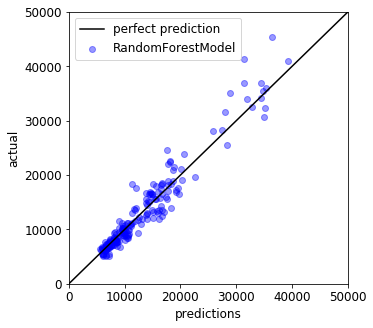

In [124]:
kf = KFold(10, shuffle=True, random_state=1)

best_model = {'criterion': 'mae', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 
         'min_samples_split': 3, 'n_estimators': 100}
model = RandomForestRegressor()
model.set_params(**best_model)  

predictions = cross_val_predict(model, numeric_cars[optimized_columns_RFR], numeric_cars['price'], cv=kf)

fig, ax = plt.subplots(figsize=(5,5))
lim = [0,50000]
ax.set_xlim(lim), ax.set_ylim(lim)

# Create a scatter plot with train and test actual vs predictions
ax.scatter(predictions, numeric_cars['price'], alpha=0.4, color='b', label='RandomForestModel')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
ax.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

<br>

## 5 - Bias vs Variance, with cross_val, for LinearRegression and RandomForestRegressor

In [113]:
def cross_val_bias_variance(features, target, fold, df, model):   
    
    N_features = []
    rmse_mean_list = []
    rmse_std_list = []
    
    for element_x in features:
        
        N_features.append(len(element_x))    
        mean_rmse_mean_all_folds = 0
        mean_rmse_std_all_folds = 0
        
        for element_y in k_folds:            
            kf = KFold(element_y, shuffle=True, random_state=1)   
            mses = cross_val_score(model, df[element_x], df[target].values.ravel(), 
                                   scoring="neg_mean_squared_error", cv=kf, error_score='raise')
            rmses = np.sqrt(np.absolute(mses))            
            mean_rmse_mean_all_folds += np.mean(rmses)/len(k_folds)
            mean_rmse_std_all_folds += np.std(rmses)/len(k_folds)  
            
        rmse_mean_list.append(mean_rmse_mean_all_folds)
        rmse_std_list.append(mean_rmse_std_all_folds)  
    
    return (N_features, rmse_mean_list, rmse_std_list)    

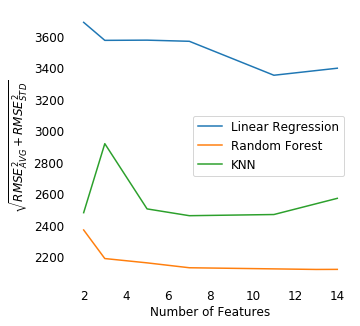

In [201]:
k_folds = np.arange(2, 100, 10)

fig, ax = plt.subplots(figsize=(5,5))

features = [['engine-size', 'horsepower'],
            ['engine-size', 'horsepower', 'wheel-base'],
            ['engine-size', 'horsepower', 'wheel-base', 'curb-weight', 'highway-mpg'],
            ['engine-size', 'horsepower', 'wheel-base', 'curb-weight', 'highway-mpg', 'width', 'city-mpg']]

#Linear Regression
model = LinearRegression()
this_features = features + [optimized_columns_LR] + [numeric_cars.columns.drop('price').tolist()]
(N_features,rmse_mean,rmse_std)=cross_val_bias_variance(this_features, 'price', k_folds, numeric_cars, model) 
ax.plot(N_features, np.sqrt(np.array(rmse_mean)**2+np.array(rmse_std)**2), label="Linear Regression")

#RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=1, min_samples_split=3)
this_features = features + [optimized_columns_RFR] + [numeric_cars.columns.drop('price').tolist()]
(N_features,rmse_mean,rmse_std)=cross_val_bias_variance(this_features, 'price', k_folds, numeric_cars, model) 
ax.plot(N_features, np.sqrt(np.array(rmse_mean)**2+np.array(rmse_std)**2), label="Random Forest")

model = KNeighborsRegressor(algorithm='ball_tree', n_neighbors=5, p=1, weights='distance')
this_features = features + [optimized_columns_LR] + [numeric_cars.columns.drop('price').tolist()]
(N_features,rmse_mean,rmse_std)=cross_val_bias_variance(this_features, 'price', k_folds, numeric_cars, model) 
ax.plot(N_features, np.sqrt(np.array(rmse_mean)**2+np.array(rmse_std)**2), label="KNN")


ax.tick_params(left=False, right=False, top=False, bottom=False)       
for key,spine in ax.spines.items():
        spine.set_visible(False) 
ax.set_ylabel("$\sqrt{RMSE_{AVG}^2+RMSE_{STD}^2}$"), ax.set_xlabel("Number of Features")

ax.legend()
plt.show()

- For Linear Regression and Random Forest, as the model complexity increases, the variance + bias descreases. The trend is reversed in the Linear Regression model for all features (14) because the model starts to overfit
- For KNN variance + bias is almost constant with number of features, except when wheel-base is included

<br>

## 6 - Predict Using Neural Networks

R^2 train 0.860
R^2 test 0.781


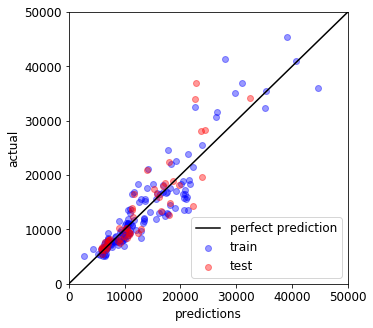

In [102]:
def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true * y_pred, 0), \
                     penalty * tf.square(y_true - y_pred), \
                     tf.square(y_true - y_pred))
    return tf.reduce_mean(loss, axis=-1) # train on last axis, the one our NN was just trained on

keras.losses.sign_penalty = sign_penalty  # enable use of loss with keras


# Create model with dropout
model_3 = Sequential()
model_3.add(Dense(1000, input_dim=train_features.shape[1], activation='relu'))
model_3.add(Dropout(0.4))
model_3.add(Dense(500, activation='relu'))
model_3.add(Dense(300, activation='relu'))
model_3.add(Dense(100, activation='relu'))
model_3.add(Dense(20, activation='relu'))
model_3.add(Dense(1, activation='linear'))

# Fit model with mean squared error loss function
#model_3.compile(optimizer='adam', loss=sign_penalty)
model_3.compile(optimizer='adam', loss='mse')
history = model_3.fit(train_features, train_targets, epochs=100, verbose=0)

train_preds = model_3.predict(train_features)
test_preds = model_3.predict(test_features)
print(f"R^2 train {r2_score(train_targets, train_preds):0.3f}")
print(f"R^2 test {r2_score(test_targets, test_preds):0.3f}")


fig, ax = plt.subplots(figsize=(5,5))
lim = [0,50000]
ax.set_xlim(lim), ax.set_ylim(lim)

ax.scatter(train_preds, train_targets, alpha=0.4, color='b', label='train')
ax.scatter(test_preds, test_targets, alpha=0.4, color='r', label='test')

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
ax.plot(np.arange(xmin, xmax, 0.01), np.arange(xmin, xmax, 0.01), c='k', label='perfect prediction')

plt.xlabel('predictions')
plt.ylabel('actual')
plt.legend()
plt.show()

<br>

## 7 - Manual Feature Selection and Hyperparameter Optimization for the best KNN model

### 7.1 - Manual Feature Selection
- first one at a time (univariate), then, different combinations of the best individual features
- model: KNN, simple train/test validation, R2 as metric

**One feature at a time: univariate KNN**

In [175]:
def knn_train_test(feature, target, df, k_value=5):    
    train = df[0:int(0.7*len(df))]
    test = df[int(0.7*len(df)):] 
    knn = KNeighborsRegressor(n_neighbors = k_value, algorithm = 'ball_tree', p=2, 
                              leaf_size=91, metric='manhattan', weights='distance')
    knn.fit(train[feature], train[target])
    predictions = knn.predict(test[feature])
    rmse = np.sqrt(np.absolute(mean_squared_error(test[target], predictions)))
    r2 = r2_score(test[target], predictions)
    return r2

features = continuous_values_cols[:]
features.remove('price')

r2_dict = {}
for element in features:     
    r2_dict[element] = knn_train_test([element], ['price'], numeric_cars, k_value=5)
    
r2_results_series = pd.Series(r2_dict)
sorted_features = r2_results_series.sort_values(ascending=False)

print("Feature Name    |    R2 Value")
print(r2_results_series.sort_values(ascending=False))

Feature Name    |    R2 Value
engine-size          0.875359
wheel-base           0.817487
horsepower           0.791940
city-mpg             0.737163
width                0.737111
length               0.691200
highway-mpg          0.632455
compression-rate     0.608196
curb-weight          0.586398
peak-rpm             0.297575
normalized-losses    0.292478
bore                 0.239750
stroke               0.223028
height               0.177472
dtype: float64


**Add the best individual features one at a time**

In [176]:
#run the model
r2 = knn_train_test(sorted_features[:2].index.tolist(), ['price'], numeric_cars, k_value=5)
print(f"R2: {r2:0.3f} {sorted_features[:2].index.tolist()}")
r2 = knn_train_test(sorted_features[:3].index.tolist(), ['price'], numeric_cars, k_value=5)
print(f"R2: {r2:0.3f} {sorted_features[:3].index.tolist()}")
r2 = knn_train_test(sorted_features[:4].index.tolist(), ['price'], numeric_cars, k_value=5)
print(f"R2: {r2:0.3f} {sorted_features[:4].index.tolist()}")
r2 = knn_train_test(sorted_features[:5].index.tolist(), ['price'], numeric_cars, k_value=5)
print(f"R2: {r2:0.3f} {sorted_features[:5].index.tolist()}")
r2 = knn_train_test(sorted_features[:6].index.tolist(), ['price'], numeric_cars, k_value=5)
print(f"R2: {r2:0.3f} {sorted_features[:6].index.tolist()}")

R2: 0.876 ['engine-size', 'wheel-base']
R2: 0.888 ['engine-size', 'wheel-base', 'horsepower']
R2: 0.889 ['engine-size', 'wheel-base', 'horsepower', 'city-mpg']
R2: 0.866 ['engine-size', 'wheel-base', 'horsepower', 'city-mpg', 'width']
R2: 0.863 ['engine-size', 'wheel-base', 'horsepower', 'city-mpg', 'width', 'length']


<br>

### 7.2 - Manual Hyperparameter Optimization (of the k-value)
- for each individual feature and k-value 1 to 15
- For the top 3 models in the last step and k-value 1 to 15 

**All features individually**

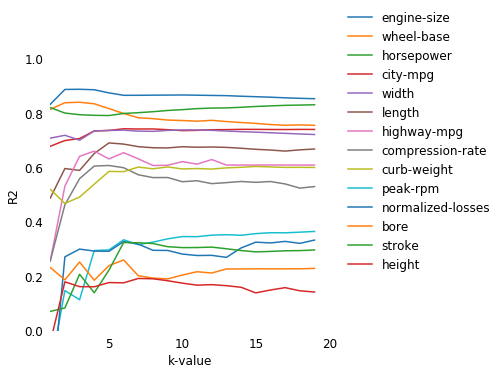

In [183]:
xlim = [1,20]
ylim = [0, 1]
fig, ax = plt.subplots(figsize=(5,5))

ax.set_ylabel("R2"), ax.set_xlabel("k-value")
ax.set_xlim(xlim), ax.set_ylim(ylim)


features = sorted_features.index.tolist()
k_values = np.arange(1,20)


r2_dict = {}
for element in features:     
    r2 = []
    for k_value in k_values:
        r2.append(knn_train_test([element], ['price'], numeric_cars, k_value=k_value))
        
    #plot results
    ax.plot(k_values, r2, label=element)

   
ax.tick_params(left=False, right=False, top=False, bottom=False)    
for key,spine in ax.spines.items():
        spine.set_visible(False)    

ax.legend(loc=[1.05,0.2], frameon=False)
plt.show()

- Independently of the value of k there are some variables which clearly hold better R2 values
- Of those engine-size, wheel-base and horsepower are the best

**Combined features (only the three best combinations from before)**

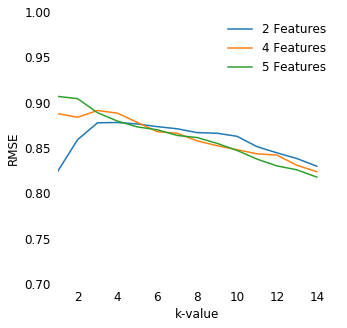

In [192]:
xlim = [1,15]
ylim = [0.7, 1]

fig, ax = plt.subplots(figsize=(5,5))
ax.set_ylabel("RMSE"), ax.set_xlabel("k-value")
ax.set_xlim(xlim), ax.set_ylim(ylim)


features = [['engine-size', 'wheel-base'],
            ['engine-size', 'wheel-base', 'horsepower', 'curb-weight'],
            ['engine-size', 'wheel-base', 'horsepower', 'curb-weight', 'highway-mpg']]

k_values = np.arange(1,15)

r2_dict = {}
for element in features:     
    r2 = []
    for k_value in k_values:
        r2.append(knn_train_test(element, ['price'], numeric_cars, k_value=k_value))
        
    #plot results
    ax.plot(k_values, r2, label=str(len(element))+' Features')
    
ax.tick_params(left=False, right=False, top=False, bottom=False)    
for key,spine in ax.spines.items():
        spine.set_visible(False) 

ax.legend(loc='best', frameon=False)
plt.show()

Best model: 5 features, k-value =1